# 8 Feature Selection

- Feature selection is about eliminating uninformative features so that computational complexity of training and inference decrease. Two main ideas play a role in the process:
    - **Variance limit**: Eliminating inputs with low variance
    - **Target relationship**: Measuring the relationship of a feature with the target variable through a chosen criteria such as correlation, mutual information etc. and then eliminating the ones with values lower than a threshold.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets
import pandas as pd

- Let's start with variance limit. Using the Iris data, we can transform dataset features with variances lower than 0.2.

In [2]:
iris_data = datasets.load_iris()
df = pd.DataFrame(data=np.c_[iris_data.data, iris_data.target], 
                  columns=list(iris_data.feature_names) + ['target'])

df.columns = ['sepal_length', 'sepal_width', 
              'petal_length', 'petal_width', 
              'target']
print(df.var())
var_limit = 0.2

drops = [item for item in df.var().index if df.var()[item] < 0.2]
df.drop(drops, inplace=True, axis=1)
df.var()

sepal_length    0.685694
sepal_width     0.189979
petal_length    3.116278
petal_width     0.581006
target          0.671141
dtype: float64


sepal_length    0.685694
petal_length    3.116278
petal_width     0.581006
target          0.671141
dtype: float64

- Or we can `sklearn` library, however results is not a `DataFrame` rather it's a numpy array.

In [3]:
from sklearn.feature_selection import VarianceThreshold
df = pd.DataFrame(data=np.c_[iris_data.data, iris_data.target], 
                  columns=list(iris_data.feature_names) + ['target'])

df.columns = ['sepal_length', 'sepal_width', 
              'petal_length', 'petal_width', 
              'target']

var_limit = VarianceThreshold(threshold=0.2)
data_transformed = var_limit.fit_transform(df)
data_transformed[:10]

array([[5.1, 1.4, 0.2, 0. ],
       [4.9, 1.4, 0.2, 0. ],
       [4.7, 1.3, 0.2, 0. ],
       [4.6, 1.5, 0.2, 0. ],
       [5. , 1.4, 0.2, 0. ],
       [5.4, 1.7, 0.4, 0. ],
       [4.6, 1.4, 0.3, 0. ],
       [5. , 1.5, 0.2, 0. ],
       [4.4, 1.4, 0.2, 0. ],
       [4.9, 1.5, 0.1, 0. ]])

- A key point is that scaling features change the mean and variance. For example given a random variable $X \sim D$ and $E[X]=\mu, Var[X] = \sigma^{2}$, scaling would generate a new random variable $Z=\frac{x - \mu}{\sigma}$ with (using linearity of expected value and variance formulas) $E[Z] = 0, Var[Z] = 1$.

- Another approach removing features with high correlation. Following example shows that `sepal_length` and `sl_square` are highly correlated, therefore a candidate for removal. 

In [4]:
df['sl_squar'] = df.sepal_length.apply(np.square)
df.corr()

,sepal_length,sepal_width,petal_length,petal_width,target,sl_squar
sepal_length,1.000000,-0.117570,0.871754,0.817941,0.782561,0.996842
sepal_width,-0.117570,1.000000,-0.428440,-0.366126,-0.426658,-0.104895
petal_length,0.871754,-0.428440,1.000000,0.962865,0.949035,0.858514
petal_width,0.817941,-0.366126,0.962865,1.000000,0.956547,0.801247
target,0.782561,-0.426658,0.949035,0.956547,1.000000,0.768566
sl_squar,0.996842,-0.104895,0.858514,0.801247,0.768566,1.000000


- Now, we can move on to target relationship which is named as *univariate feature selection*. In short, we choose a feature and measure its relationship with the target variable using a certain criteria. Note that $\chi^{2}$ is only for non-negative data. 

- Following `class` chooses either k best features or percentage of feature ranked according to given criteria.

In [5]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile


class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        
        if problem_type == "classification":
            valid_scoring = {
                'f_classif': f_classif,
                'chi2' : chi2,
                'mutual_info_classif': mutual_info_classif
            }
        else:
            valid_scoring = {
                'f_regression': f_regression,
                'mutual_info_regression': mutual_info_regression
            }
            
        if scoring not in valid_scoring:
            raise Exception('Invalid Scoring Function')
        
        if isinstance(n_features, int):
            self.selection = SelectKBest(
            valid_scoring[scoring],
            k=n_features)
            
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
            valid_scoring[scoring],
            percentile=int(n_features*100)
            )
        else:
            raise Exception('Invalid type of features')
            
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
                

- Using `iris` dataset, we can show how selection works.

In [7]:
X, y = datasets.load_iris(return_X_y=True)

ufs = UnivariateFeatureSelection(n_features=3, 
                                 problem_type='regression', scoring='f_regression')

ufs.fit(X,y)
X_transformed = ufs.transform(X)
X_transformed[:10]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2],
       [4.6, 1.5, 0.2],
       [5. , 1.4, 0.2],
       [5.4, 1.7, 0.4],
       [4.6, 1.4, 0.3],
       [5. , 1.5, 0.2],
       [4.4, 1.4, 0.2],
       [4.9, 1.5, 0.1]])

- Greedy feature selection first evaluates the score of a single feature, then adds another to check whether is the score improved. If no improvement is achieved, it stops and returns the selected features. Since model performance is measured over and over again with different combinations of features, it's rather costly.

In [36]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification, make_regression
iterations = [0]

class GreedyFeatureSelection:
    
    def evaluate_score(self, X, y):
        
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:,1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc
    
    def _feature_selection(self, X, y):
        global iterations
        good_features = []
        best_scores = []
        
        num_features = X.shape[1]
        
        while True:
            count = 0
            
            this_feature = None
            best_score = 0
            
            for feature in range(num_features):
                count += 1
                if feature in good_features:
                    continue
                selected_features = good_features + [feature]
                xtrain = X[:, selected_features]
                score = self.evaluate_score(xtrain, y)
                
                if score > best_score:
                    this_feature = feature
                    best_score = score
                    
            if this_feature != None:
                good_features.append(this_feature)
                best_scores.append(best_score)
            iterations.append(iterations[-1]+count)
            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                    break
                    
        return best_scores[:-1], good_features[:-1]
    
    def __call__(self, X, y):
        scores, features = self._feature_selection(X, y)
        return X[:,features], scores
    
X, y = make_classification(n_samples=1000, n_features=10)
print(f'Feature size {X.shape}')
X_transformed, scores = GreedyFeatureSelection()(X, y)
print(f'Feature size transformed {X_transformed.shape}')

print(f'Scores {scores}\nIterations{iterations[1:-1]}')

Feature size (1000, 10)
Feature size transformed (1000, 7)
Scores [0.9218507496119938, 0.9276388422214754, 0.9280748491975872, 0.9282468519496312, 0.9283868541896669, 0.9283988543816701, 0.9284068545096722]
Iterations[10, 20, 30, 40, 50, 60, 70]


- Recursive feature elimination

In [46]:
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X = data['data']
col_names = data['feature_names']
y = data['target']

model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=3)

X_transformed = rfe.fit_transform(X, y)

- Feature importance 

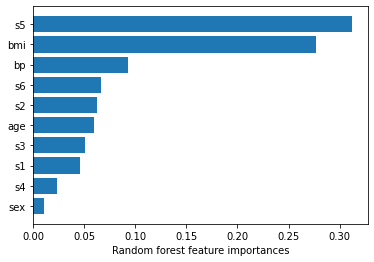

In [52]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

data = load_diabetes()
X = data['data']
col_names = data['feature_names']
y = data['target']

model = RandomForestRegressor()
model.fit(X,y)

importances = model.feature_importances_
idxs = np.argsort(importances)

plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random forest feature importances')
plt.show()

- Also we can use or interpret another model's parameters as feature importance metric.

In [53]:
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

data = load_diabetes()
X = data['data']
y = data['target']
col_names = data['feature_names']

model = RandomForestRegressor()
sfm = SelectFromModel(estimator=model)
X_transform = sfm.fit_transform(X, y)

support = sfm.get_support()

print([x for x, y in zip(col_names, support) if y == True])

['bmi', 's5']
